# 1. Local Minima and Himmelblau

The Himmelblau function serves as another popular test function for optimization algorithms as it is non-convex and multi-modal. It is defined by 

$$
f(x,y) = (x^2 + y - 11)^2 + (x+y^2-7)^7,
$$

and has one local maximum at $x=0.270845$,$y=-0.923039$ with $f(x,y)= 181.617$ as well as four local identical minima:

$$
f(3,2)= f(-2.805118,3.131312) = f(-3.779310,-3.283186) = f(3.584428,-1.848126) = 0.
$$

Again, to get an idea what the Himmelblau function looks like, we plot it:

In [2]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

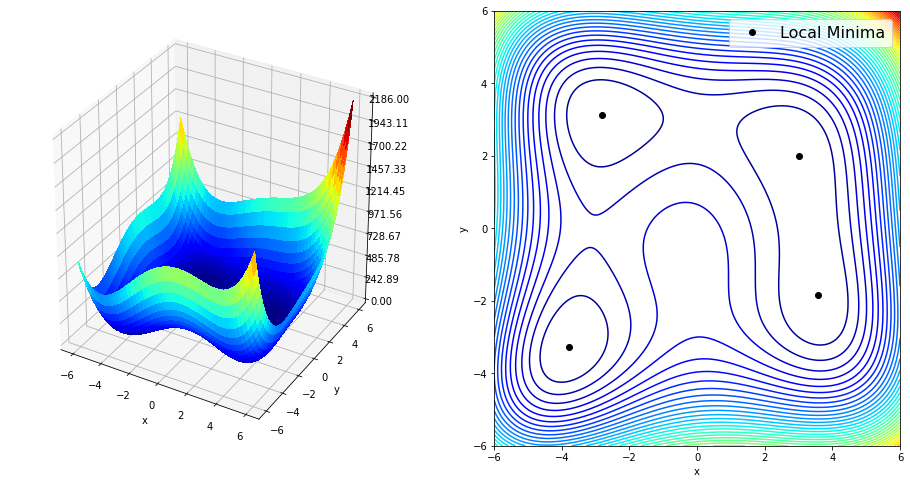

In [3]:
#define himmelblau function
def himmelblau(x):
    value = (x[0]**2+x[1]-11)**2 + (x[1]**2+x[0]-7)**2 
    return value

def himmelblau_xy(x,y):
    return himmelblau((x,y))

def plot_himmelblau():
    "Draw a surface and contour plot of the Himmelblau function on [-6,6]x[-6,6]"
    xx = np.linspace(-6,6,250)
    yy = np.linspace(-6,6,250)
    X, Y = np.meshgrid(xx, yy)
    Z = himmelblau_xy(xx[None,:], yy[:,None])
    fig = plt.figure(figsize = (16,8))
    #Surface plot
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='jet',
                       linewidth=0, antialiased=False)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    #Contour plot
    ax = fig.add_subplot(1, 2, 2)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.contour(X,Y,Z, 50, cmap = 'jet')
    ax.plot(3, 2, 'ko', label = "Local Minima")
    ax.plot(-2.805118,3.131312, 'ko')
    ax.plot(-3.779310, -3.283186, 'ko')
    ax.plot(3.584428, -1.848126, 'ko')
    ax.legend(prop={"size":16})
    return fig, ax

# Draw plot of Himmelblau function with four local minima
fig, ax = plot_himmelblau()

We want to optimize the Himmelblau function with its special structure with the Nelder-Mead algorithm. Given below is a code that has starting point $(0,0)$ which is in the middle of all local minima. Can you guess to what of the four local minimum it will converge?

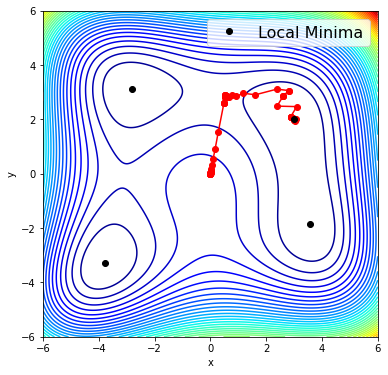

In [4]:
# function to trace back all x-values
x0 = np.array([0,0])
ps = [x0];
def call_back(p):
    global ps
    ps.append(p)

res = minimize(himmelblau, ps, method='nelder-mead', callback=call_back)
#print(ps)

ps = np.array(ps)
# Contour plot
xx = np.linspace(-6,6,250)
yy = np.linspace(-6,6,250)
X, Y = np.meshgrid(xx, yy)
Z = himmelblau(np.vstack([X.ravel(), Y.ravel()])).reshape((250,250))
fig = plt.figure(figsize = (6,6))
plt.xlabel('x')
plt.ylabel('y')
plt.contour(X,Y,Z, 50, cmap = 'jet')
plt.plot(ps[:, 0], ps[:, 1], '-ro')
plt.plot(3, 2, 'ko', label = "Local Minima")
plt.plot(-2.805118,3.131312, 'ko')
plt.plot(-3.779310, -3.283186, 'ko')
plt.plot(3.584428, -1.848126, 'ko')
plt.legend(prop={"size":16})
plt.show()

### Question:
- Try the minimization for the following initial guesses: $x_0=(0,0)$, $x_1(-5,-5)$, $x_2(5,-3)$, $x_3(-0.5,0)$ and $x_4(1,-4)$. What do you observe?

After answering the last question, it would be interesting to get an overall sense of what starting point converges to what minima. We will make a plot for this:   

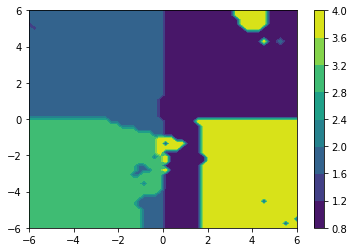

In [5]:
xx = np.linspace(-6,6,50)
yy = np.linspace(-6,6,50)
X, Y = np.meshgrid(xx, yy)
himmel_value = np.zeros_like(X)

for i in range(0,X.shape[0]):
	for j in  range(0,X.shape[1]):
		res = minimize(himmelblau, [np.array([X[i,j],Y[i,j]])], method='nelder-mead')
		if np.linalg.norm(res.x-np.array([3,2])) < 0.5:
			himmel_value[i,j] = 1;
		elif np.linalg.norm(res.x-np.array([-2.805118,3.131312])) < 0.5:
			himmel_value[i,j] = 2;
		elif np.linalg.norm(res.x-np.array([-3.779310,-3.283186])) < 0.5:
			himmel_value[i,j] = 3;
		else:
			himmel_value[i,j] = 4;
        
plt.contourf(X,Y,himmel_value)
plt.colorbar()
plt.show()

### Questions/Tasks:
- Do you find something surprising in that plot? If yes, pick that point and let it run in the above minimization. 
- Depending on your computer power, try this with a finer grid, e.g., 100x100. 

# 2. Gauß-Newton and Bezier curves
### Task:
Use Gauß-Newton to find the control points for a cubic Bezier curve $p(t)$ in $\mathbb{R}^2$ such that $p(0) = (0,0)$ and $p(1) = (0, -\pi)$ and 

$$\sum_{j=0}^{100} f(p(j/100))^2$$

is minimal, where

$$f(x, y) = \cos(x) \sin(y) + x^2 \,.$$  

We will help you to break it down a bit: 

### What are Bezier curves?

Bezier curves are widely used in computer graphics (e.g., Inkscape, Adobe) to model smooth curves. A *Bezier curve of degree $n$* is the curve traced out by

$$
  p(t) = \sum_{i=0}^n p_i B_i^n(t), \quad t \in [0,1]
$$

where the points $p_i \in \mathbb{R}^2$ are *control points* and
the functions $B_i^n(t)$ are the *Bernstein polynomials*

$$
  B_i^n(t) = C^n_i (1-t)^{n-i} t^i \quad C^n_i = \frac{n!}{i!(n-i)!}.
$$

A common type of Bezier curve used in applications is the *cubic Bezier curve* defined by four control points. As in the task above the first and last control points are given by $p(0)$ and $p(1)$, we need to optimize for the *two remaining points*. Please find in the following a cubic Bezier curve with four control points for illustration:

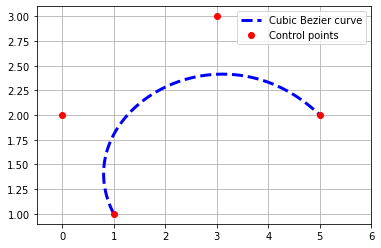

In [76]:
def Bcubic(n=100):
    "Evaluate basis for cubic Bezier"
    ts = np.linspace(0, 1, n)
    B0 = (1 - ts)**3
    B1 = 3 * (1 - ts)**2 * ts
    B2 = 3 * (1 - ts) * ts**2
    B3 = ts**3
    Bt = np.array([B0, B1, B2, B3]).T
    return Bt

def get_points(q, Bt):
    xs = Bt.dot([q[0], q[2], q[4], q[6]])
    ys = Bt.dot([q[1], q[3], q[5], q[7]])
    return xs, ys

# Set up basis
Bt = Bcubic()

# Control points (-1,1), (0,2), (3,3), (5,2)
q = np.array([1, 1, 0, 2, 3, 3, 5, 2])

# get points on curve
xs, ys = get_points(q, Bt)
plt.plot(xs, ys, 'b--', linewidth=3, label="Cubic Bezier curve")
plt.plot(1,1, 'ro', label = "Control points")
plt.plot(0,2, 'ro')
plt.plot(3,3, 'ro')
plt.plot(5,2, 'ro')
plt.grid()
plt.legend()
plt.xlim(-0.5,6)
plt.show()

As this is a nonlinear problem, we cannot use a linear least-squares algorithm here, but the Gauß-Newton method, which is an optimizer for nonlinear least-squares problems. Recall that our objective function in the nonlinear least-squares problem reads

$$
\sum_{j=0}^{100} \left( f\left(p\left(\frac{j}{100}\right)\right) - 0 \right)^2 \rightarrow \text{minimize} \, .
$$

### Questions:
- Can you recall the basic idea of Gauß-Newton?
- What is the geometric interpretation of the curve we are seeking here? 

So lets execute the Gauß-Newton algorithm below in order to find the sought Bezier curve.  

Residual norm: 7.117540174475489
Residual norm: 0.3955033403572781
Residual norm: 0.0007800774549694254
Residual norm: 6.101747483080439e-08
Residual norm: 1.143079502829939e-10


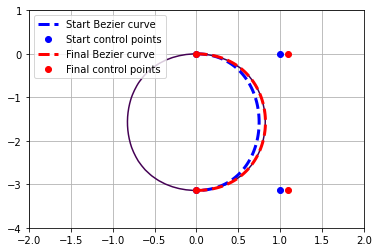

In [77]:
def f(x, y):
    return np.cos(x) * np.sin(y) + x**2

def Bcubic(n=100):
    "Evaluate basis for cubic Bezier"
    ts = np.linspace(0, 1, n)
    B0 = (1 - ts)**3
    B1 = 3 * (1 - ts)**2 * ts
    B2 = 3 * (1 - ts) * ts**2
    B3 = ts**3
    Bt = np.array([B0, B1, B2, B3]).T
    return Bt

def get_points(q, Bt):
    xs = Bt.dot([0.0, q[0], q[1], 0.0])
    ys = Bt.dot([0.0, q[2], q[3], -np.pi])
    return xs, ys

# Contour plot of ground truth
xx = np.linspace(-2, 2)
yy = np.linspace(-4, 1)
X, Y = np.meshgrid(xx, yy)
Z = f(xx[None,:], yy[:,None])
plt.contour(X, Y, Z, 'k--',levels=[0.0])

# Set up basis
Bt = Bcubic()

# Plot initial guess at solution
q = np.array([1, 1, 0, -np.pi])
xs, ys = get_points(q, Bt)
plt.plot(xs, ys, 'b--', linewidth=3, label = "Start Bezier curve")
plt.plot(0,0, 'bo', label = "Start control points")
plt.plot(1,0, 'bo')
plt.plot(1,-np.pi, 'bo')
plt.plot(0,-np.pi, 'bo')

# Run Gauss-Newton iteration
for k in range(5):
    xs, ys = get_points(q, Bt)
    Fq = f(xs, ys)
    dFdx = -np.sin(xs) * np.sin(ys) + 2*xs
    dFdy =  np.cos(xs) * np.cos(ys)
    Jq = np.array([dFdx*Bt[:,1], dFdx*Bt[:,2], dFdy*Bt[:,1], dFdy*Bt[:,2]]).T
    print("Residual norm: {0}".format(np.linalg.norm(Jq.T.dot(Fq))))
    q -= np.linalg.lstsq(Jq, Fq, rcond=None)[0]

# Plot solution
xs, ys = get_points(q, Bt)
plt.plot(xs, ys, 'r--', linewidth=3, label = 'Final Bezier curve')
plt.plot(0,0, 'ro', label = "Final control points")
plt.plot(q[0],q[2], 'ro')
plt.plot(q[1],q[3], 'ro')
plt.plot(0,-np.pi, 'ro')
plt.legend()
plt.grid()
plt.xlim(-2,2)

plt.show()

### Tasks/Questions:
- Try starting point $q=(-1,-1,0,-\pi)$. What do you expect? 
- Do you know any other optimizers for nonlinear least squares problems? 